In [1]:
# # https://github.com/maxw1489/Mask_RCNN (tensorflow 2.9.1)

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print("Num GPUs Available: ",
len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

2.15.0
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4619202513643952293
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22500343808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10529334501181734329
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:
import logging
import os
import json
import cv2
import sys
import math
import random
import warnings

import cv2

import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

dir_root = os.path.abspath("./")

# sys.path.append(os.path.join(dir_root, "maskrcnn/Mask_RCNN-master/"))  # To find local version
# sys.path.append(os.path.join(dir_root, "maskrcnn/Mask_RCNN-master_tf2p9/"))  # To find local version
# sys.path.append(os.path.join(dir_root, "maskrcnn/mask-rcnn-tf2-us-main/"))  # To find local version

# sys.path.append(os.path.join(dir_root, "maskrcnn/mask-rcnn-tf2-us-main/samples/coco/"))  # To find local version


from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

import imgaug as ia
import imgaug.augmenters as iaa



logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    # 0 = all messages are logged (default behavior)
    # 1 = INFO messages are not printed
    # 2 = INFO and WARNING messages are not printed
    # 3 = INFO, WARNING, and ERROR messages are not printed


warnings.filterwarnings('ignore')

In [4]:
# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices("GPU") 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
NUM_OF_IMAGES = 40
NUM_OF_VAL_IMAGES = 40

dir_img = os.path.join(dir_root, "images/images_2D/images/")
dir_mask = os.path.join(dir_root, "images/images_2D/masks/")
dir_model = os.path.join(dir_root, "logs/")

# class_dict = {"Karton": 1, "Außensohle": 2, "Innensohle": 3, "Obermaterial": 4, "Zunge": 5, "Füllmaterial": 6}
class_dict = {"Außensohle": 1, "Innensohle": 2, "Obermaterial": 3, "Füllmaterial": 4}
len(class_dict)

4

In [6]:
# due to the different naming of the shoes (images and masks) we have to create a dict to map the images to an unique id

shoe_img_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                 "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                 "Citywalk-sit-taupe-34_down2_2_2": 5, "Citywalk-sit-taupe-36_down2_2_2": 6, 
                 "Citywalk-sit-taupe-39_down2_2_2": 7, "Citywalk-sit-taupe-40_down2_2_2": 8, 
                 "Citywalk-sit-taupe-42_down2_2_2": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                 "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                 "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                 "McKinley_Anton_down2_2_2": 15, "Mustang-Sch-Navy-Metalli-35_down2_2_2": 16, 
                 "Mustang-Sch-Navy-Metalli-40_down2_2_2": 17, "Mustang-Sch-Navy-Metalli_31_down2_2_2": 18, 
                 "Mustang-Sch-Navy-Metalli_36_down2_2_2": 19, "Mustang-Sch-Navy-Metalli_37_down2_2_2": 20, 
                 "Pertolio-dunkelbraun_43_down2_2_2": 21, "Petrolio-Sch-dunkelbraun_42_down2_2_2": 22, 
                 "Petrolio-Sch-dunkelbraun_44_down2_2_2": 23, "Petrolio-Sch-dunkelbraun_46_down2_2_2": 24,
                 "PetrolioSch-40-float_down2_2_2": 25, "Puma_38_down2_2_2": 26, 
                 "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                 "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                 "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                 "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                 "Stiefel-XY_40_down2_2_2": 35, "Tamaris-Pump-Schwarz-38_down2_2_2": 36, 
                 "Tamaris-Pump-schwarz_36_down2_2_2": 37, "Tamaris-Pump-Schwarz_39_down2_2_2": 38, 
                 "Tamaris-Pump-schwarz_40_down2_2_2": 39, "Tamaris-Pump-schwarz_42_down2_2_2": 40}

shoe_mask_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                  "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                  "Citywalk 34": 5, "Citywalk 36": 6, 
                  "Citywalk 39": 7, "Citywalk 40": 8, 
                  "Citywalk 42": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                  "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                  "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                  "McKinley_Anton": 15, "Mustang 35": 16, 
                  "Mustang 40": 17, "Mustang 31": 18, 
                  "Mustang 36": 19, "Mustang 37": 20, 
                  "Petrolio 43": 21, "Petrolio 42": 22, 
                  "Petrolio 44": 23, "Petrolio 46": 24, 
                  "Petrolio 40": 25, "Puma_38_down2_2_2": 26, 
                  "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                  "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                  "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                  "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                  "StiefelXY": 35, "TamarisPump 38": 36,
                  "TamarisPump 36": 37, "TamarisPump 39": 38, 
                  "TamarisPump 40": 39, "TamarisPump 42": 40}

In [7]:
class ShoeConfig(Config):
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = "60_Shoes_shvit_"

    BACKBONE = "shvit" # "resnet101"

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a SHViT  backbone.
    BACKBONE_STRIDES = [8, 16, 32, 64, 128] # 128 added as they add 64 in the paper (original strides were [4,8,16,32] -> [4,8,16,32,64], maybe because P5 was upsampled by factor 2??)
    # BACKBONE_STRIDES= [4, 8, 16, 32, 64] # resnet

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels resnet
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) # anchor side in pixels shvit    


    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(class_dict)  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512 # 128
    IMAGE_MAX_DIM = 512 # 128


    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = int(NUM_OF_IMAGES / IMAGES_PER_GPU)

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = int(NUM_OF_VAL_IMAGES / IMAGES_PER_GPU)

    # Shape of output mask
    # To change this you also need to change the neural network mask branch
    # # MASK_SHAPE = [28, 28] 

    RUN_EAGERLY = False  



ShoeConf = ShoeConfig()
ShoeConf.display()


Configurations:
BACKBONE                       shvit
BACKBONE_STRIDES               [8, 16, 32, 64, 128]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [8]:
class ShoeDataset(utils.Dataset):

    def load_dataset(self, dataset_dir, mask_dir):
        # Add classes
        for idx in class_dict:
            self.add_class("dataset", class_dict[idx], idx)


        # find and add all images
        for filename_img in os.listdir(dataset_dir):
            if filename_img.split("_layer")[0] not in shoe_img_dict:
                continue
            else:
                image_path = os.path.join(dataset_dir, filename_img)
                image = cv2.imread(image_path)#, cv2.IMREAD_GRAYSCALE) ################# <<<<<<---- we have grayscale images, however, coco images are rgb ...
                height, width = image.shape[:2]

                id = None
                filename_mask = None

                key = filename_img.split("_layer")[0]
                if key in shoe_img_dict:
                    id = shoe_img_dict[key]

                for key, value in shoe_mask_dict.items():
                    if value == id:
                        filename_mask = key
                        break       

                self.add_image("dataset", 
                                image_id=id-1, 
                                path=os.path.join(dataset_dir, filename_img),
                                path_mask=os.path.join(mask_dir, filename_mask),
                                width=width, 
                                height=height
                                )
                

    def get_box_mask_class(self, file):
        return cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        class_idx = []
        masks = []

        filename = info["path_mask"]
        directory_name = os.path.dirname(filename)

        for idx in class_dict:
            mask_filename = os.path.basename(filename + "_" + idx)
            files = [f for f in os.listdir(directory_name) if f.startswith(mask_filename)] # for the moment there should be only one file in the directory -> files[0] (will take the first in the list ...)
            m = self.get_box_mask_class(os.path.join(directory_name, files[0]))
            m = cv2.resize(m, (info["width"], info["height"]), interpolation=cv2.INTER_NEAREST) # i.e. StiefelXY: original image and masks have different sizes (968x1130) vs (971x1101) ...
            m = np.clip(m, 0, 1)
            if np.max(m) > 0: # check, if mask is empty
                masks.append(m)
                class_idx.append(class_dict[idx])

        masks = np.transpose(np.asarray(masks, dtype=np.uint8), (1,2,0))
        class_idx = np.asarray(class_idx, dtype=np.int32)
        
        return masks, class_idx


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info




train_dataset = ShoeDataset()
valid_dataset = ShoeDataset()

train_dataset.load_dataset(dir_img, dir_mask)
train_dataset.prepare()

valid_dataset.load_dataset(dir_img, dir_mask)
valid_dataset.prepare()

In [9]:
valid_dataset.class_names

['BG', 'Außensohle', 'Innensohle', 'Obermaterial', 'Füllmaterial']

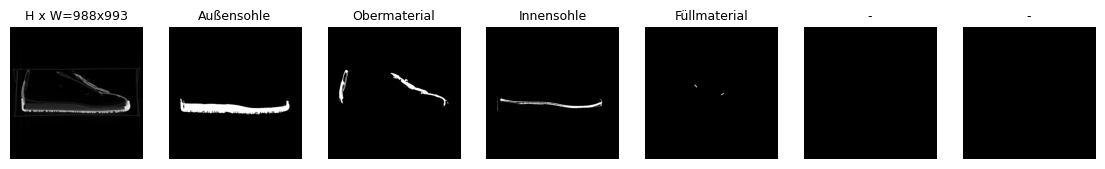

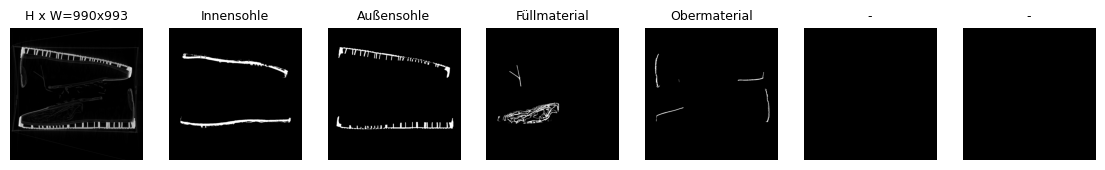

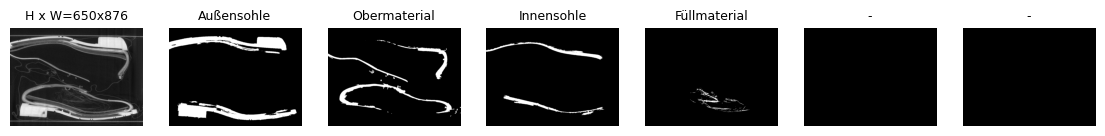

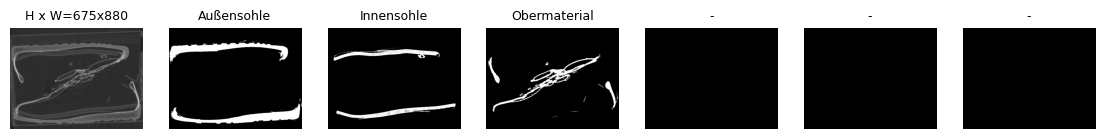

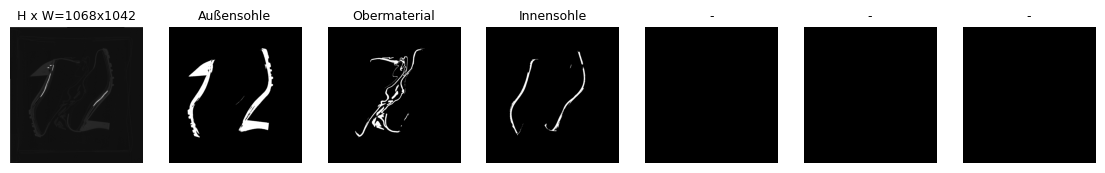

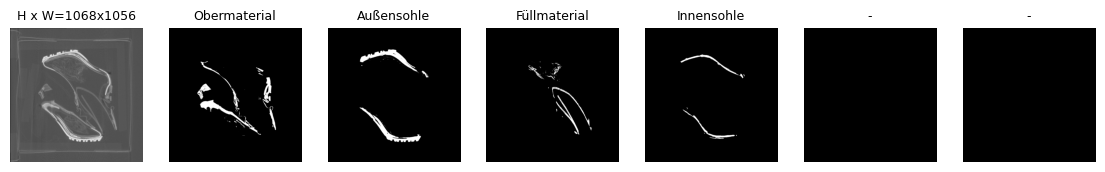

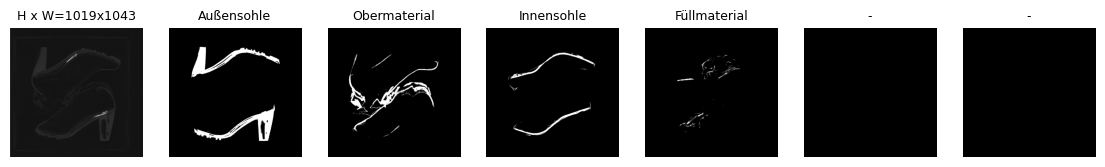

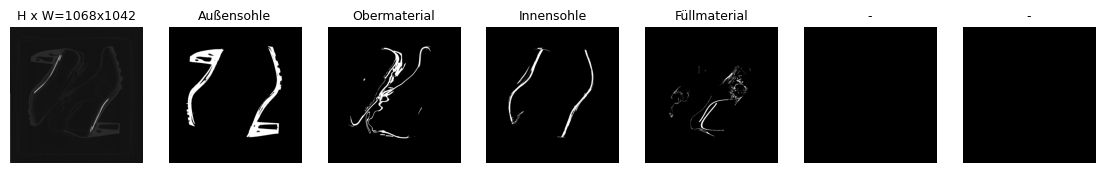

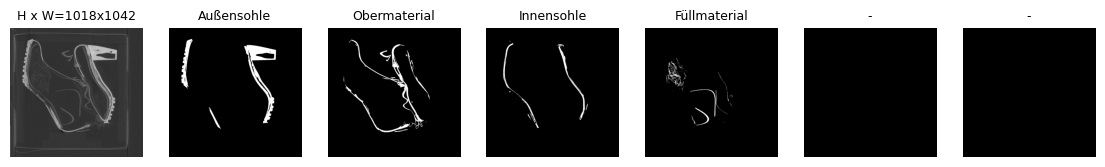

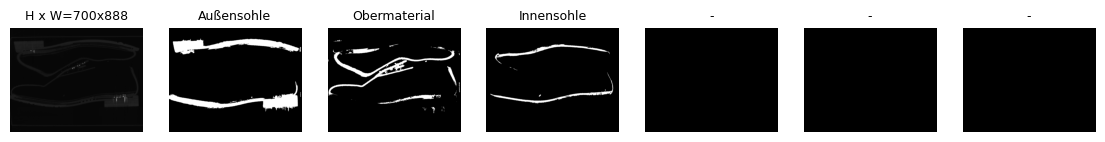

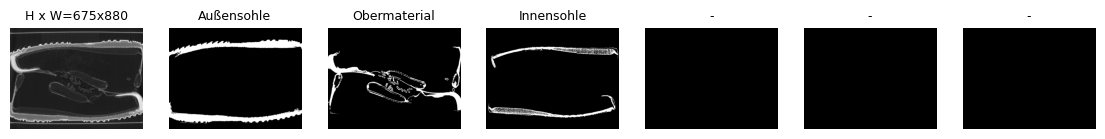

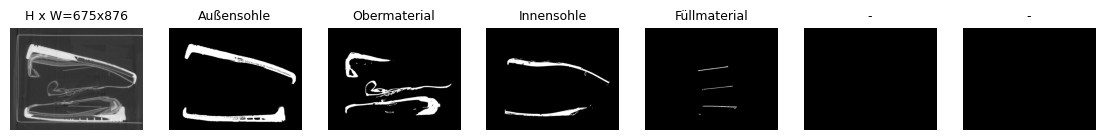

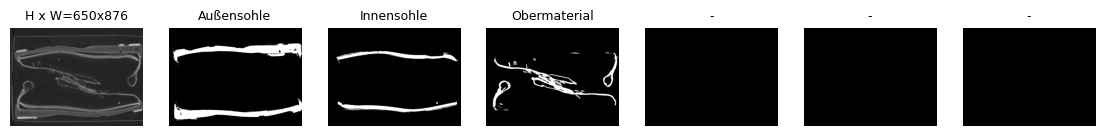

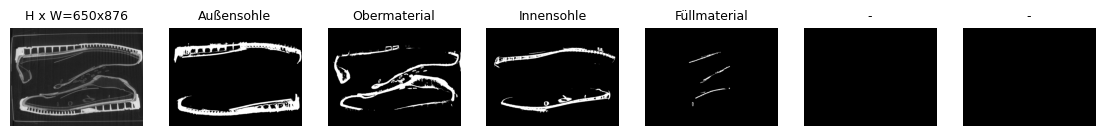

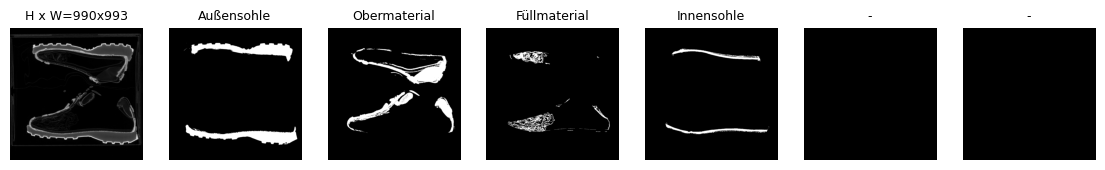

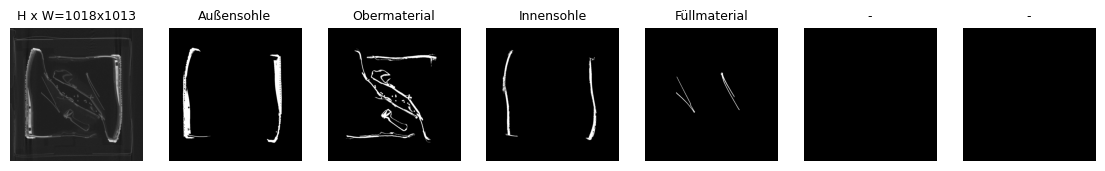

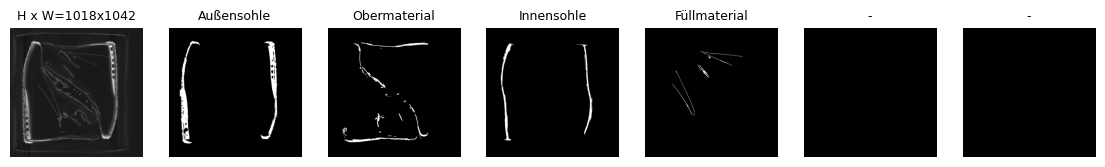

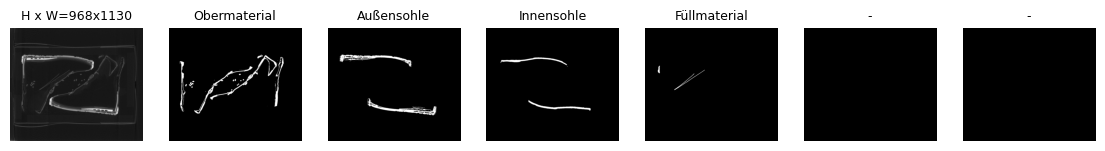

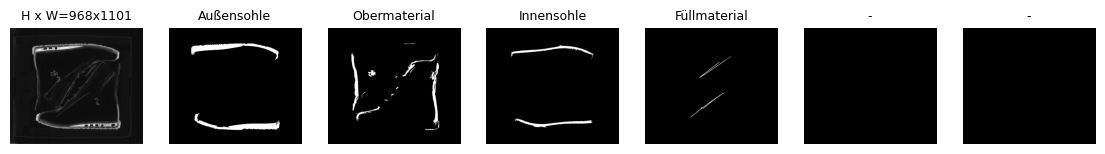

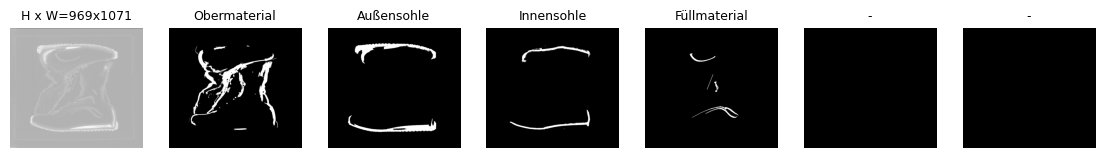

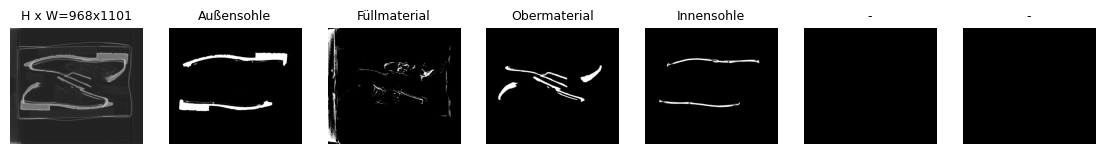

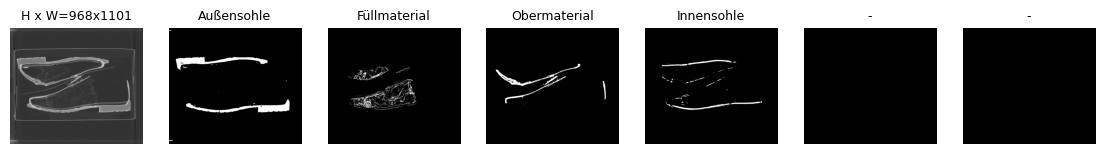

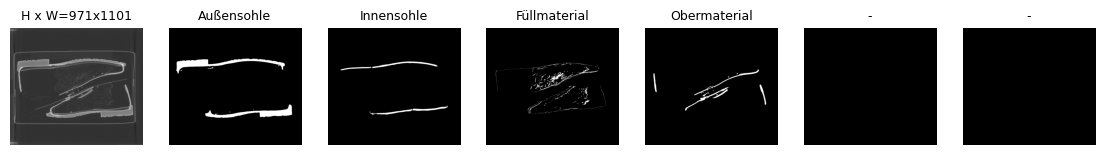

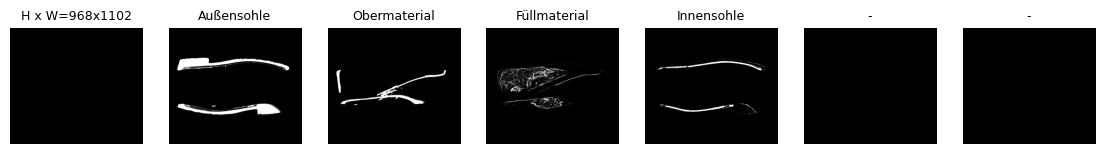

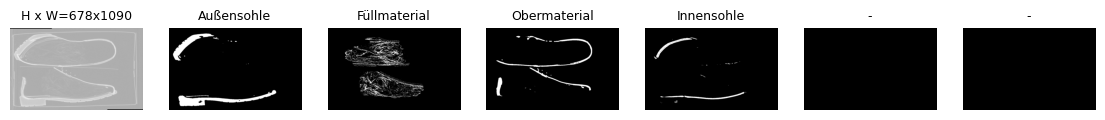

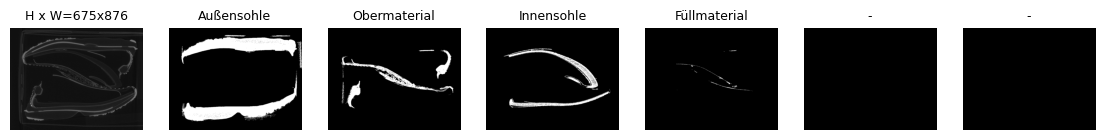

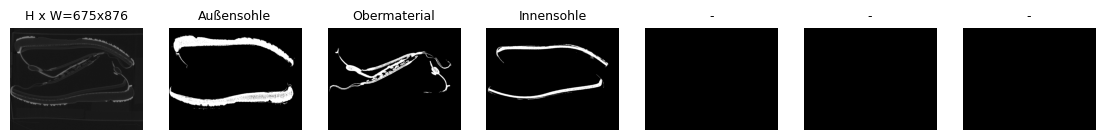

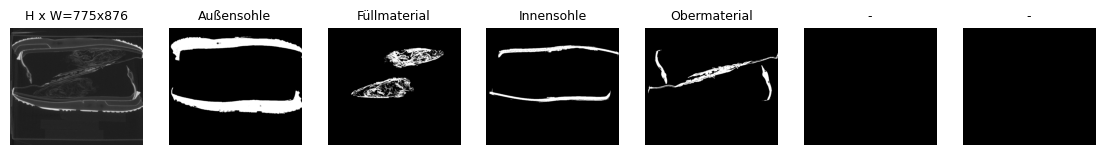

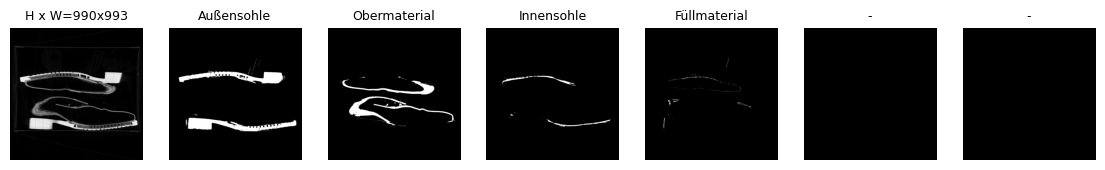

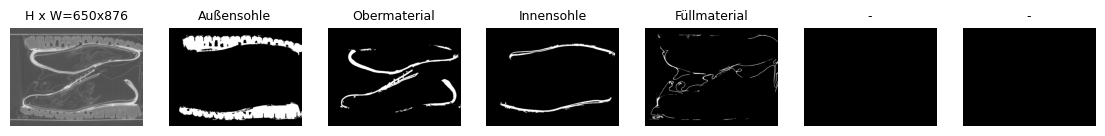

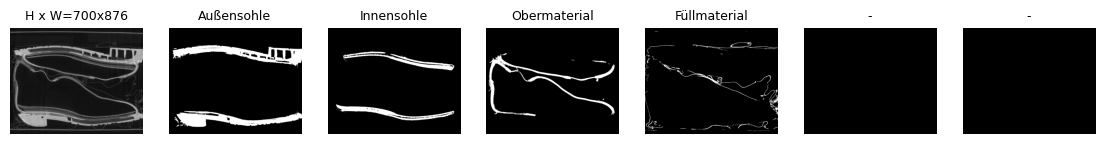

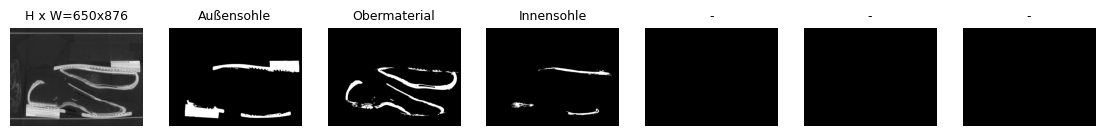

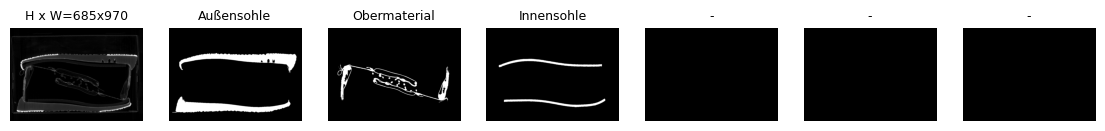

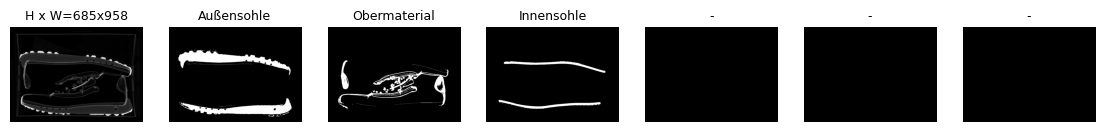

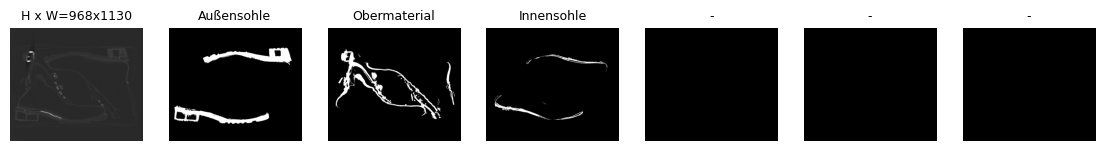

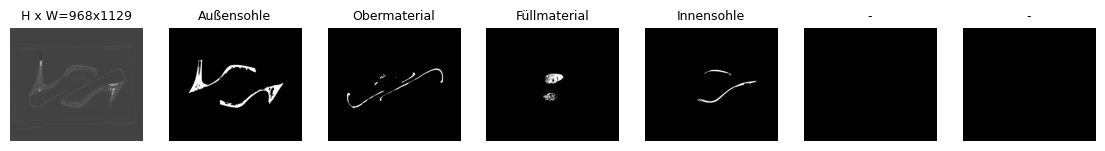

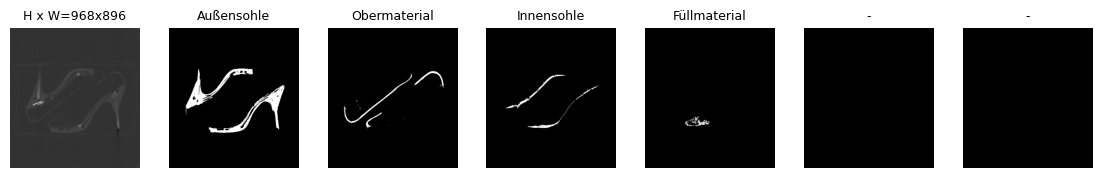

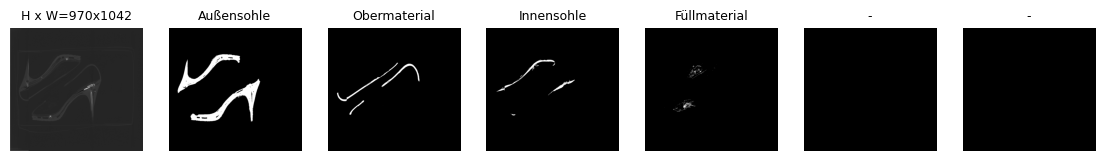

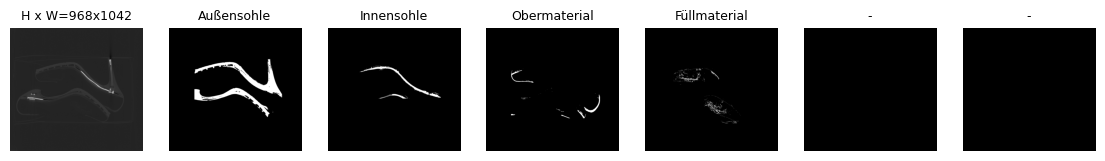

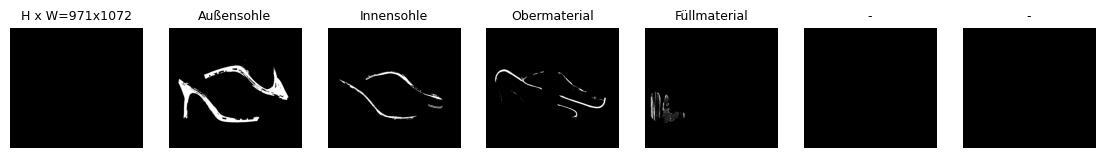

In [10]:
# image_ids = np.random.choice(train_dataset.image_ids, 40)

# for image_id in image_ids:
for image_id in range(len(shoe_img_dict)):
    image = valid_dataset.load_image(image_id)
    mask, class_ids = valid_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, valid_dataset.class_names, limit=6)

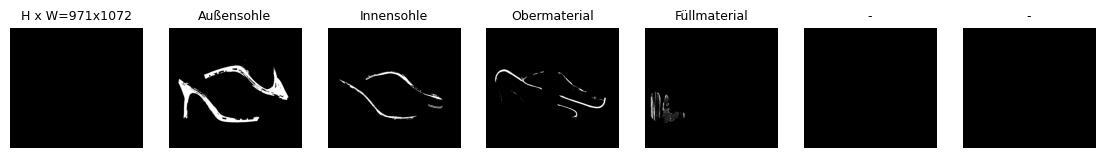

In [11]:
image_ids = np.random.choice(train_dataset.image_ids, len(shoe_img_dict))


image = train_dataset.load_image(image_id)
mask, class_ids = train_dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=6)

## Create Model and Load Trained Weights

In [12]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augmentation = iaa.Sequential([
                                iaa.Fliplr(0.5), 
                                iaa.Flipud(0.5),
                                #sometimes(iaa.Crop(percent=(0, 0.1))),
                                sometimes(iaa.Affine(
                                            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                            rotate=(-45, 45),
                                            #shear=(-16, 16),
                                            #order=[0, 1],
                                            #cval=(0, 255),
                                            #mode=ia.ALL
                                            )
                                        ),
                            ])

In [13]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="training", config=ShoeConf, model_dir=dir_model)

# Load weights trained on MS-COCO
if ShoeConf.BACKBONE=="resnet101":
    COCO_MODEL_PATH = os.path.join(dir_root, "mask_rcnn_coco.h5")    
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [14]:
EPOCHS = [1,100,500]
initial_learning_rate = 1e-3
warmup_epochs = 10


def lr_warmup(epoch, initial_learning_rate, warmup_epochs):
    if epoch < warmup_epochs:
        warmup_lr = initial_learning_rate * (epoch + 1) / (warmup_epochs)
        return warmup_lr
    return None  # Use None to indicate that the reduced learning rate should be used


class WarmupSchedulerWithReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, warmup_epochs, reduce_lr_on_plateau):
        super(WarmupSchedulerWithReduceLROnPlateau, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_epochs = warmup_epochs
        self.reduce_lr_on_plateau = reduce_lr_on_plateau

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = lr_warmup(epoch, self.initial_learning_rate, self.warmup_epochs)
        if new_lr is not None:
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"Epoch {epoch+1}: Learning rate is {new_lr:.6f} (warmup phase).")
        else:
            # Delegate to ReduceLROnPlateau's functionality
            self.reduce_lr_on_plateau.on_epoch_begin(epoch, logs)


reduce_lr_on_plateau  = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, min_lr=1e-8)
warmup_with_reduce_lr_callback = WarmupSchedulerWithReduceLROnPlateau(initial_learning_rate, warmup_epochs, reduce_lr_on_plateau)
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

csv_logger_head = tf.keras.callbacks.CSVLogger(filename=ShoeConf.NAME + "_training.log", append=False)
csv_logger_all = tf.keras.callbacks.CSVLogger(filename=ShoeConf.NAME + "_training.log", append=True)

In [15]:
model.compile(layers="head")
model.summary()

Selecting layers to train
Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_bn (Conv2d_BN)       (None, None, None, 28)       868       ['input_image[0][0]']         
                                                                                                  
 conv2d_bn_1 (Conv2d_BN)     (None, None, None, 56)       14336     ['conv2d_bn[0][0]']           
                                                                                                  
 conv2d_bn_2 (Conv2d_BN)     (None, None, None, 112)      56896     ['conv2d_bn_1[0][0]']         
                                                                

In [16]:
model.train(train_dataset, valid_dataset, 
            epochs=EPOCHS[0], 
            augmentations=None, #augmentation, 
            custom_callbacks=[stop_early, warmup_with_reduce_lr_callback, csv_logger_head])
history = model.keras_model.history.history


Starting at epoch 0.

Checkpoint Path: /mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/02_Vision_Transformers/logs/60_shoes_shvit_20241211T0222/mask_rcnn_60_shoes_shvit__{epoch:04d}.h5
n workers used: 32
Epoch 1: Learning rate is 0.000100 (warmup phase).


W0000 00:00:1733880161.090635 1105673 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -775 } dim { size: -151 } dim { size: -152 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -50 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 22500343808 

10/10 [==============================] - ETA: 0s - loss: 24416458.0000 - rpn_class_loss: 7680836.0000 - rpn_bbox_loss: 10141603.0000 - mrcnn_class_loss: 6769623.0500 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

W0000 00:00:1733880168.631014 1105673 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -775 } dim { size: -151 } dim { size: -152 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -50 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 22500343808 

10/10 [==============================] - 14s 681ms/step - loss: 24416458.0000 - rpn_class_loss: 7680836.0000 - rpn_bbox_loss: 10141603.0000 - mrcnn_class_loss: 6753658.7727 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 24381468.0000 - val_rpn_class_loss: 7645848.0000 - val_rpn_bbox_loss: 10141604.0000 - val_mrcnn_class_loss: 6594015.5000 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


In [17]:
model.compile(layers="all")
model.summary()

Selecting layers to train
conv2d_bn              (Conv2d_BN)
conv2d_bn_1            (Conv2d_BN)
conv2d_bn_2            (Conv2d_BN)
conv2d_bn_3            (Conv2d_BN)
blocks1_i              (Sequential)
blocks2_s              (Sequential)
blocks3_s              (Sequential)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
anchors                (ConstLayer)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeD

In [18]:
model.train(train_dataset, valid_dataset, 
            epochs=EPOCHS[1], 
            augmentations=None, #augmentation, 
            custom_callbacks=[stop_early, warmup_with_reduce_lr_callback, csv_logger_all])
new_history = model.keras_model.history.history
for k in new_history: 
    history[k] = history[k] + new_history[k]


Starting at epoch 1.

Checkpoint Path: /mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/02_Vision_Transformers/logs/60_shoes_shvit_20241211T0222/mask_rcnn_60_shoes_shvit__{epoch:04d}.h5
n workers used: 32
Epoch 2: Learning rate is 0.000200 (warmup phase).
Epoch 2/100


W0000 00:00:1733880187.171971 1105673 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1390 } dim { size: -830 } dim { size: -831 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -67 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -67 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 22500343808

10/10 [==============================] - ETA: 0s - loss: 13.0675 - rpn_class_loss: 2.9692 - rpn_bbox_loss: 5.6600 - mrcnn_class_loss: 2.7236 - mrcnn_bbox_loss: 1.3412 - mrcnn_mask_loss: 0.2112

W0000 00:00:1733880203.452643 1105673 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -775 } dim { size: -151 } dim { size: -152 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -50 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 22500343808 

10/10 [==============================] - 34s 680ms/step - loss: 13.0675 - rpn_class_loss: 2.9692 - rpn_bbox_loss: 5.6600 - mrcnn_class_loss: 2.5945 - mrcnn_bbox_loss: 1.4693 - mrcnn_mask_loss: 0.2268 - val_loss: 4799.9092 - val_rpn_class_loss: 111.2694 - val_rpn_bbox_loss: 3828.5183 - val_mrcnn_class_loss: 2.6860 - val_mrcnn_bbox_loss: 856.6993 - val_mrcnn_mask_loss: 0.7368
Epoch 3: Learning rate is 0.000300 (warmup phase).
Epoch 3/100
10/10 [==============================] - 5s 472ms/step - loss: 5.7443 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 2.8853 - mrcnn_class_loss: 0.3692 - mrcnn_bbox_loss: 2.1714 - mrcnn_mask_loss: 0.4626 - val_loss: 378.2017 - val_rpn_class_loss: 5.4339 - val_rpn_bbox_loss: 302.2679 - val_mrcnn_class_loss: 0.1642 - val_mrcnn_bbox_loss: 69.5059 - val_mrcnn_mask_loss: 0.8299
Epoch 4: Learning rate is 0.000400 (warmup phase).
Epoch 4/100
10/10 [==============================] - 5s 466ms/step - loss: 4.6858 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 2.7365 - mrcnn_

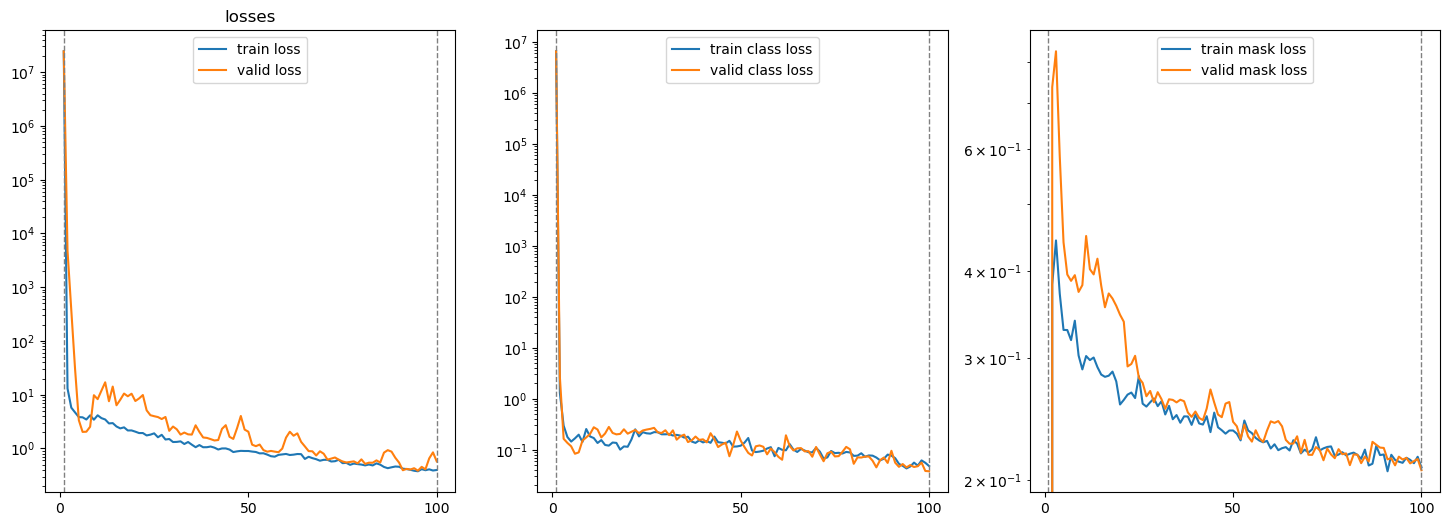

In [19]:
epochs = range(len(list(history["loss"])))
epochs = tuple(e + 1 for e in epochs)


plt.figure(figsize=(18, 6))

plt.subplot(131, title="losses")
plt.plot(epochs, history["loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="valid loss")
plt.xticks(range(0, epochs[-1]+1, 50))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="train class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="valid class loss")
plt.xticks(range(0, epochs[-1]+1, 50))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.subplot(133)
plt.plot(epochs, history["mrcnn_mask_loss"], label="train mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="valid mask loss")
plt.xticks(range(0, epochs[-1]+1, 50))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.show()

In [20]:
class InferenceConfig(ShoeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=dir_model)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/02_Vision_Transformers/logs/60_shoes_shvit_20241211T0222/mask_rcnn_60_shoes_shvit__0095.h5
Re-starting from epoch 95


/mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/02_Vision_Transformers/images/images_2D/images/Tamaris-Pump-Schwarz_39_down2_2_2_layer_364.png
Processing 1 images
image                    shape: (970, 1042, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1042.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35425  max:    1.10376  float32


W0000 00:00:1733880588.954799 1105673 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -479 } dim { size: 64 } dim { size: 64 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -45 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -45 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 22500343808 ban

[[ 274    0  275 1042]
 [ 299 1041  300 1042]
 [ 327 1041  328 1042]
 [ 326 1041  327 1042]
 [ 328 1041  329 1042]
 [ 326 1041  327 1042]
 [ 327 1041  328 1042]
 [ 328 1041  329 1042]
 [ 334 1041  335 1042]
 [ 325 1041  326 1042]
 [ 329 1041  330 1042]
 [ 329 1041  330 1042]
 [ 326 1041  327 1042]
 [ 325 1041  326 1042]
 [ 326 1041  327 1042]
 [ 325 1041  326 1042]
 [ 323 1041  324 1042]
 [ 319 1041  320 1042]
 [ 323 1041  324 1042]
 [ 322 1041  323 1042]
 [ 321 1041  322 1042]
 [ 321 1041  322 1042]
 [ 331 1041  332 1042]
 [ 323 1041  324 1042]
 [ 327 1041  328 1042]
 [ 330 1041  331 1042]
 [ 332 1041  333 1042]
 [ 332 1041  333 1042]
 [ 331 1041  332 1042]
 [ 331 1041  332 1042]
 [ 358 1041  359 1042]
 [ 343 1041  344 1042]
 [   0 1041  970 1042]
 [   0    0  970    1]
 [ 418 1041  419 1042]
 [   0 1041  970 1042]
 [   0 1041  970 1042]
 [   0 1041  970 1042]
 [   0 1041  970 1042]
 [   0 1041  970 1042]
 [ 434 1041  435 1042]
 [   0 1041  970 1042]
 [   0 1041  970 1042]
 [   0 1041

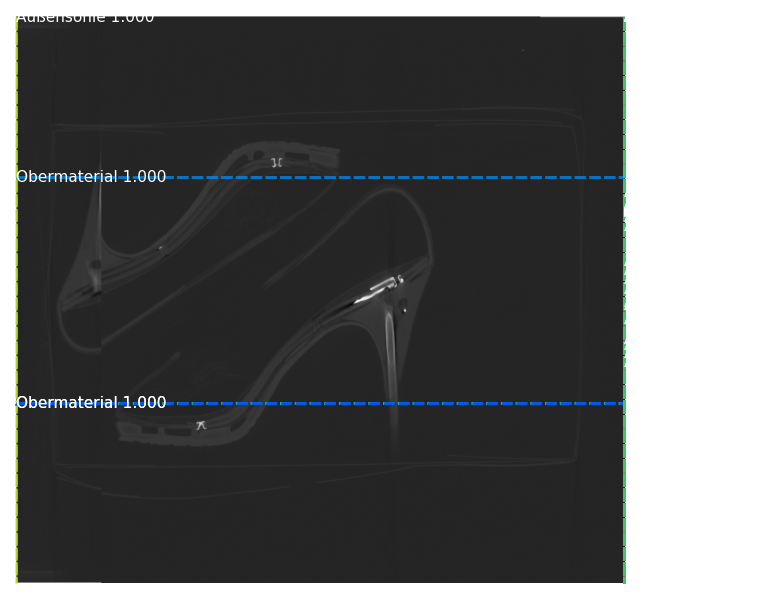

In [21]:
file_names = next(os.walk(dir_img))[2]
file = os.path.join(dir_img, random.choice(file_names))
print(file)
image = cv2.imread(file)

# Run detection
results = model.detect([image], verbose=1)
res = results[0]
print(res["rois"])
print(res["class_ids"])
print(res["scores"])
print(valid_dataset.class_names)

# Visualize results
visualize.display_instances(image, res["rois"], res["masks"], res["class_ids"], valid_dataset.class_names, res["scores"], figsize=(8, 8))

In [ ]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id) # ground truth
log("gt_bbox", gt_bbox) # ground truth
log("gt_mask", gt_mask) # ground truth

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_val.class_names, figsize=(8, 8))

original_image           shape: (512, 512, 3)         min:    0.00000  max:    0.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1072.00000  float64
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (4, 4)                min:   23.00000  max:  461.00000  int32
gt_mask                  shape: (512, 512, 4)         min:    0.00000  max:    1.00000  bool


: 